# SIFT Image matching

Detecting features and computing descriptors for the query image...
Done.
Matching features with scene image: ../data/manhattan_dataset/scene_images\manhattan_image_reference1.png


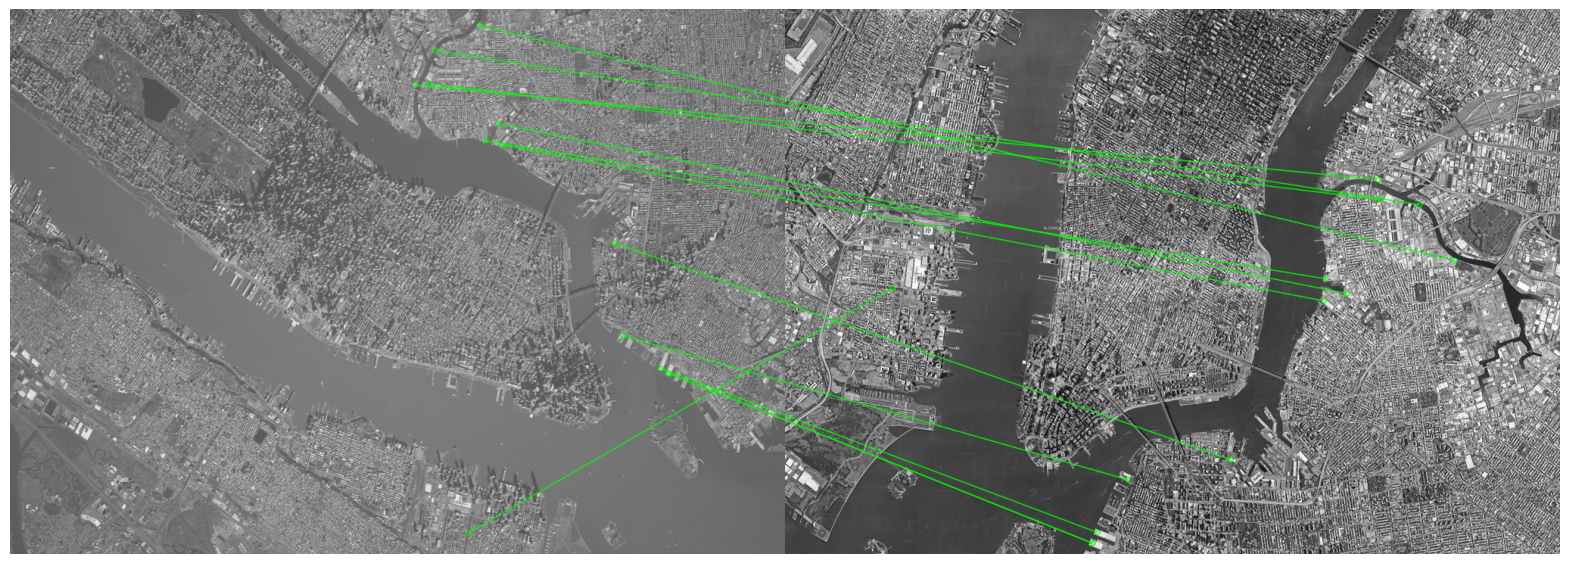

Matching Percentage with ../data/manhattan_dataset/scene_images\manhattan_image_reference1.png: 76.47%
Matching features with scene image: ../data/manhattan_dataset/scene_images\manhattan_image_reference2.png


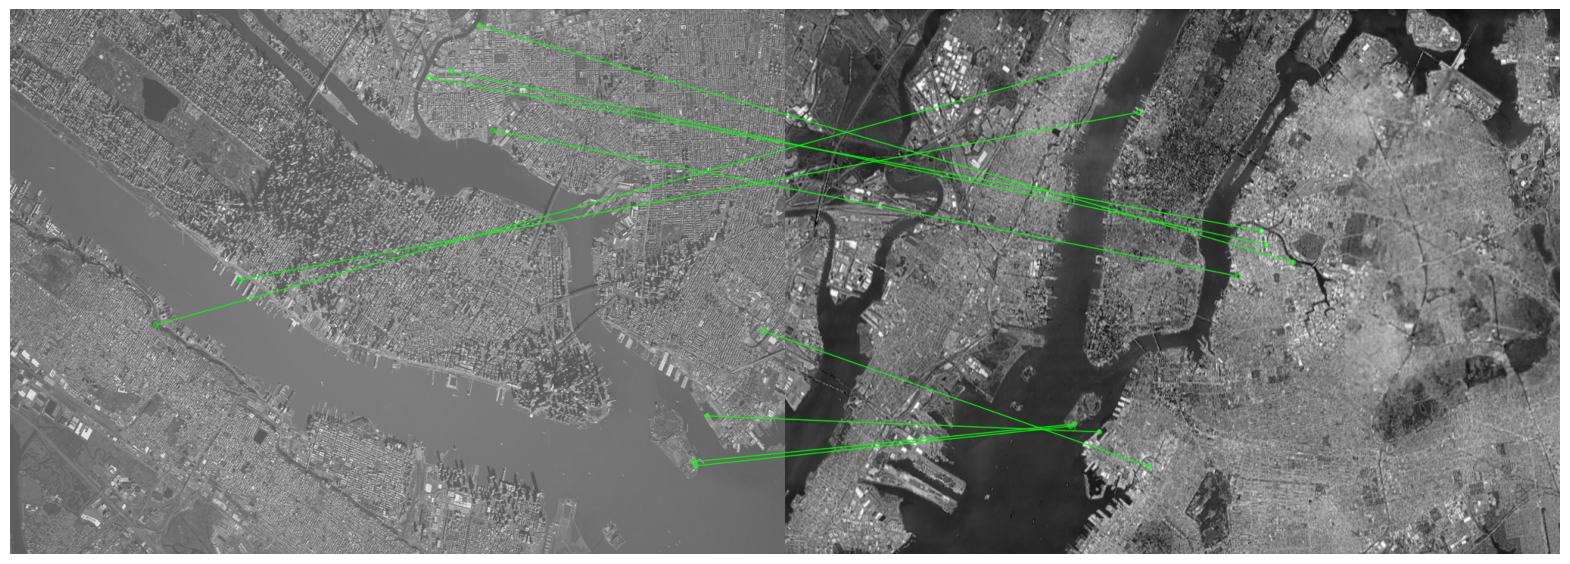

Matching Percentage with ../data/manhattan_dataset/scene_images\manhattan_image_reference2.png: 52.63%
Matching features with scene image: ../data/manhattan_dataset/scene_images\manhattan_image_reference3.png
Not enough matches are found for ../data/manhattan_dataset/scene_images\manhattan_image_reference3.png - 5/10


In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sift_detect_and_compute(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
    return matches

def filter_good_matches(matches):
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

def find_homography(keypoints1, keypoints2, good_matches):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M, mask

def visualize_matches(image1, keypoints1, image2, keypoints2, matches, mask):
    draw_params = dict(matchColor=(0, 255, 0), 
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),
                       flags=2)
    img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, **draw_params)
    
    # Convert BGR to RGB for matplotlib
    img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.axis('off') # Hide the axis
    plt.show()

def match_query_to_scene(query_image, scene_image_path):
    # Load the scene image
    scene_image = cv2.imread(scene_image_path, cv2.IMREAD_GRAYSCALE)

    # Check if image loaded correctly
    if scene_image is None:
        raise ValueError(f"Could not load the scene image from path: {scene_image_path}")

    print(f"Matching features with scene image: {scene_image_path}")
    keypoints_scene, descriptors_scene = sift_detect_and_compute(scene_image)

    matches = match_features(descriptors_query, descriptors_scene)
    good_matches = filter_good_matches(matches)

    if len(good_matches) > 10:
        M, mask = find_homography(keypoints_query, keypoints_scene, good_matches)
        matchesMask = mask.ravel().tolist()
        num_inliers = sum(matchesMask)
        matching_percentage = (num_inliers / len(good_matches)) * 100
        visualize_matches(query_image, keypoints_query, scene_image, keypoints_scene, good_matches, mask)
        print(f"Matching Percentage with {scene_image_path}: {matching_percentage:.2f}%")
    else:
        print(f"Not enough matches are found for {scene_image_path} - {len(good_matches)}/{10}")


# Load the query image
query_image_path = '../data/manhattan_dataset/manhattan_query_image.jpg'
query_image = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)

# Check if query image loaded correctly
if query_image is None:
    raise ValueError("Could not load the query image. Check the file path.")

print("Detecting features and computing descriptors for the query image...")
keypoints_query, descriptors_query = sift_detect_and_compute(query_image)
print("Done.")

# Path to the folder containing all the scene images
scene_images_folder = '../data/manhattan_dataset/scene_images/*'

# Use glob to find all the image files in the folder
scene_images_paths = glob.glob(scene_images_folder)

# Check if scene images are found
if not scene_images_paths:
    raise ValueError(f"No images found in the folder: {scene_images_folder}")

# Match query image to each scene image
for scene_image_path in scene_images_paths:
    match_query_to_scene(query_image, scene_image_path)